In [1]:
import sys
!{sys.executable} -m pip install pydicom PyAthena

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.8 MB/s eta 0:00:00:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import boto3
import tempfile
from tqdm.notebook import tqdm as with_progress_bar
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd

import scipy.stats
from sklearn import linear_model
import matplotlib.pyplot as plt

import pydicom #!{sys.executable} -m pip install pydicom

from pyathena import connect #!{sys.executable} -m pip install PyAthena
from pyathena.cursor import DictCursor

Matplotlib is building the font cache; this may take a moment.


In [3]:
s3 = boto3.client("s3")
cfn = boto3.client("cloudformation")

# Background

Modern clinical analysis projects may include data from several different modalities—genomics data, clinical observations, and imaging data may all be part of a patient’s case. Unfortunately, these data types are often kept in different formats and located in different places, so gathering and managing them in a coherent can be challenging. For example, NCI has several open datasets containing genomics data, patient clinical data, and imaging data. Some of this data is accessible through The Cancer Genome Atlas ([TCGA](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga)) and associated API's, and the imaging data is stored in The Cancer Imaging Archive ([TCIA](https://wiki.cancerimagingarchive.net/)). The data is linked by the unique identifier assigned to patients during the studies, but it is difficult to link datasets with distinct API's.
Here, we used [AWS Glue](https://aws.amazon.com/glue/) ETL jobs to organize this disparate data into S3 buckets. 

Once in S3, we can easily link the datasets using [AWS Athena](https://aws.amazon.com/athena/) to query across different tables and pull information for analysis.

What follows is a brief demonstration of how a researcher might build a cohort and use multimodal data for a analysis process.

# Basic Athena queries for multimodal cohort building

We have tables crawled by glue and stored in `s3` buckets containing patient test data and patient clinical metadata. First we connect to the database and create an Athena cursor to query. 

In [4]:
import os, jmespath

session = boto3.session.Session()
region = session.region_name
print(region)

project_name = os.environ.get('RESOURCE_PREFIX')
database_name = project_name.lower()
work_group_name = project_name.lower() + '-' + region
print('Project:', project_name)
print('Database:', database_name)
print('Work Group:', work_group_name)

resources = cfn.describe_stacks(StackName='{0}-Pipeline'.format(project_name))
query = 'Stacks[].Outputs[?OutputKey==`DataLakeBucket`].OutputValue'
data_lake_bucket = path = jmespath.search(query, resources)[0][0]
print('S3 bucket:', data_lake_bucket)

us-west-1
Project: GenomicsAnalysis
Database: genomicsanalysis
Work Group: genomicsanalysis-us-west-1
S3 bucket: genomicsanalysis-pipeline-datalakebucket-tvpzhmu7lrij


In [6]:
conn = connect(s3_staging_dir=f's3://{data_lake_bucket}/query-output',
               region_name=region,
               schema_name=database_name)
cursor = conn.cursor(DictCursor, work_group=work_group_name)

Next, we will count the number of unique patients in our full dataset:

In [7]:
STATEMENT = 'SELECT COUNT(DISTINCT bcr_patient_barcode) AS all_patients FROM clinical_patient;'
query_res = cursor.execute(STATEMENT).fetchall()
print(f"There are {query_res[0]['all_patients']} patients.")

There are 1026 patients.


Let's quickly look at the age distribution of our patients. If no age is recorded for a patient, we'll set them to -1 to distinguish them from the main age distribution.

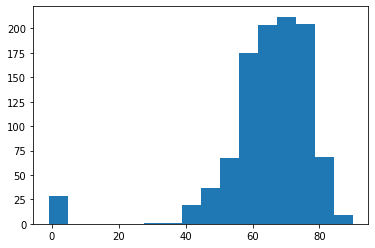

In [8]:
STATEMENT = 'SELECT age_at_initial_pathologic_diagnosis AS dx_age FROM clinical_patient;'
query_res = cursor.execute(STATEMENT).fetchall()
ages = []
for row in query_res:
    try:
        ages.append(int(row['dx_age']))
    except ValueError:
        ages.append(-1)
plt.hist(ages, bins=16)
plt.show()

## Narrowing the cohort

Let's now look to see how many patients have tumor mutation data recorded in their clinical history. Our clinical data has records for EGFR, KRAS, and ALK-EML4 translocation status, but for the purposes of this analysis, let's focus only on EGFR.

In [9]:
STATEMENT = """
SELECT egfr_mutation_status, egfr_mutation_identified_type
FROM clinical_patient
"""
query_res = cursor.execute(STATEMENT).fetchall()
egfr_status = pd.DataFrame(query_res)
egfr_status.value_counts()

egfr_mutation_status  egfr_mutation_identified_type
NO                    [Not Available]                  474
[Not Available]       [Not Available]                  395
YES                   [Not Available]                   76
[Unknown]             [Not Available]                   55
YES                   Other                             10
                      Exon 19 Deletion                   9
                      L858R                              4
NO                    Other                              1
YES                   L861Q                              1
                      T790M                              1
dtype: int64

It appears that 450 patients out of our full set of 1026 do not have EGFR mutation status recorded in their clinical history. Additionally, most of the patients who have an identified EGFR mutation do not have any data available about their mutation type. We will try to enrich that data by searching for specific EGFR mutations in the `tcga_mutation` table.

In [10]:
STATEMENT = """
WITH egfr_mutation_type AS (
  SELECT submitter_id, array_agg(distinct variant_type) as variant_type, 
    array_agg(distinct hgvsp_short) as hgvsp_short
  FROM tcga_mutation
  WHERE hugo_symbol = 'EGFR'
  AND (exon_number = '19/28' and variant_type = 'DEL') 
   OR (hgvsp_short = 'p.L858R')
   OR (hgvsp_short = 'p.T790M')
   OR (hgvsp_short = 'p.L861Q')
  GROUP BY submitter_id
)

SELECT bcr_patient_barcode, egfr_mutation_status, egfr_mutation_identified_type,
  egfr_mutation_type.variant_type, egfr_mutation_type.hgvsp_short
FROM clinical_patient
LEFT JOIN egfr_mutation_type ON bcr_patient_barcode = egfr_mutation_type.submitter_id
"""
egfr_status_enhanced = pd.DataFrame(cursor.execute(STATEMENT).fetchall())
egfr_status_enhanced[["egfr_mutation_status", "egfr_mutation_identified_type", "variant_type"]].value_counts()

egfr_mutation_status  egfr_mutation_identified_type  variant_type
NO                    [Not Available]                [SNP]           13
[Not Available]       [Not Available]                [DEL]           11
NO                    [Not Available]                [DEL]           10
[Not Available]       [Not Available]                [SNP]            9
YES                   Exon 19 Deletion               [DEL]            7
                      L858R                          [SNP]            3
                      Exon 19 Deletion               [SNP]            1
                      L861Q                          [SNP]            1
                      Other                          [DEL]            1
                      T790M                          [SNP]            1
[Unknown]             [Not Available]                [SNP]            1
dtype: int64

With the mutation data, we're able to identify 21 additional patients with either Exon 19 Deletion or one of the three common SNPs. Interestingly, 23 additional patients were identified as having an EGFR mutation through the mutation data, who were recorded as having no EGFR mutation in their clinical history.

Let's save the list of patient IDs having EGFR mutations for further analysis.

In [11]:
egfr_snp_mut = egfr_status_enhanced[egfr_status_enhanced.variant_type.isin(('[SNP]','[DEL]'))]
print(f'We have {len(egfr_snp_mut)} patients in our cohort.')

We have 58 patients in our cohort.


## Image analysis

Let's see how many patients in our small cohort have image data available.


In [12]:
patient_ids = '(' + ','.join(f"'{p}'" for p in egfr_snp_mut['bcr_patient_barcode']) + ')'
STATEMENT = """
SELECT arbitrary(imgs.collection), arbitrary(imgs.patientid) as patient_id, imgs.seriesinstanceuid AS series_uid, 
       arbitrary(imgs.seriesdescription) as description, arbitrary(imgs.modality) as mod
FROM tcia_image_series imgs
WHERE imgs.patientid IN {patient_ids}
GROUP BY imgs.seriesinstanceuid
""".format(patient_ids=patient_ids)
res_all_img_study = pd.DataFrame(cursor.execute(STATEMENT).fetchall())
res_all_img_study

,_col0,patient_id,series_uid,description,mod
0,TCGA-LUAD,TCGA-J2-8192,1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112...,SAG CHEST,CT
1,TCGA-LUAD,TCGA-J2-8192,1.3.6.1.4.1.14519.5.2.1.3983.9002.138321164626...,SOFT TISSUE,CT
2,TCGA-LUAD,TCGA-38-6178,1.3.6.1.4.1.14519.5.2.1.8421.9002.241095233362...,coronals,PT
3,TCGA-LUAD,TCGA-38-4628,1.3.6.1.4.1.14519.5.2.1.8421.9002.101564030988...,LOCALIZER,CT
4,TCGA-LUAD,TCGA-50-6591,1.3.6.1.4.1.14519.5.2.1.6450.9002.160846153697...,Topogram,CT
5,TCGA-LUAD,TCGA-50-6591,1.3.6.1.4.1.14519.5.2.1.6450.9002.846229601736...,CT Spiral 5.0 B70s,CT
6,TCGA-LUAD,TCGA-50-6591,1.3.6.1.4.1.14519.5.2.1.6450.9002.198989343210...,FUSED PET/CT,CT
7,TCGA-LUAD,TCGA-38-6178,1.3.6.1.4.1.14519.5.2.1.8421.9002.570696184372...,Reformatted,CT
8,TCGA-LUAD,TCGA-38-6178,1.3.6.1.4.1.14519.5.2.1.8421.9002.500879414859...,PE STUDY ST,CT
9,TCGA-LUAD,TCGA-38-6178,1.3.6.1.4.1.14519.5.2.1.8421.9002.904457022040...,CT WB 5.0 B30f,CT


To visualize the patient images, we retrieve them directly from the TCIA API to the data lake bucket, and then visualize them using Matplotlib within the notebook.

In [13]:
import io
import requests
from zipfile import ZipFile

TCIA_API = "https://services.cancerimagingarchive.net/services/v4/TCIA/query/"
S3_RESOURCE = boto3.resource("s3")

def get_image_stream_unzip(seriesuid, bucket_name=data_lake_bucket):
    """Get Zip file from API, unpack in memory and write to S3 bucket"""
    url = TCIA_API + "getImage"
    parameters = {"SeriesInstanceUID": seriesuid}
    output_keys = []
    with requests.get(url, params=parameters, stream=True) as req:
        req.raise_for_status()
        with io.BytesIO() as byte_stream:
            for chunk in req.iter_content(chunk_size=10000):
                byte_stream.write(chunk)
            with ZipFile(byte_stream, "r") as zo:
                list_of_files = [i for i in zo.namelist() if i.endswith("dcm")]
                for dcm in list_of_files:
                    item = zo.read(dcm)
                    bucket_key = f"tcia-images/{seriesuid}/{dcm.replace('./', '')}"
                    S3_RESOURCE.Bucket(bucket_name).put_object(Key=bucket_key, Body=item)
                    print(f"Writing DICOM object: {bucket_key} to bucket: {bucket_name}")
                    output_keys.append(bucket_key)
    return output_keys

def get_dicom_from_s3(dicom_bucket, dicom_key):
    # retrieve and load the dicom file
    with tempfile.TemporaryFile() as tmpf:
        S3_RESOURCE.Bucket(dicom_bucket).download_fileobj(dicom_key, tmpf)
        tmpf.seek(0)
        dcm = pydicom.dcmread(tmpf)
        return dcm
    
def show_dicom(dcm):
    # render a dicom using matplotlib
    if len(dcm.pixel_array.shape) == 3:
        pixels = dcm.pixel_array.sum(axis=0)
    else:
        pixels = dcm.pixel_array
        
    plt.figure(figsize=(6,6), dpi=100)
    plt.imshow(pixels, cmap=plt.cm.gray)

In [14]:
dicom_keys = get_image_stream_unzip(res_all_img_study['series_uid'][0])

Writing DICOM object: tcia-images/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981/1-117.dcm to bucket: genomicsanalysis-pipeline-datalakebucket-tvpzhmu7lrij
Writing DICOM object: tcia-images/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981/2-118.dcm to bucket: genomicsanalysis-pipeline-datalakebucket-tvpzhmu7lrij
Writing DICOM object: tcia-images/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981/3-119.dcm to bucket: genomicsanalysis-pipeline-datalakebucket-tvpzhmu7lrij
Writing DICOM object: tcia-images/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981/4-120.dcm to bucket: genomicsanalysis-pipeline-datalakebucket-tvpzhmu7lrij
Writing DICOM object: tcia-images/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981/5-121.dcm to bucket: genomicsanalysis-pipeline-datalakebucket-tvpzhmu7lrij
Writing DICOM object: tcia-images/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981/6-122.dcm to bucket: genomicsan

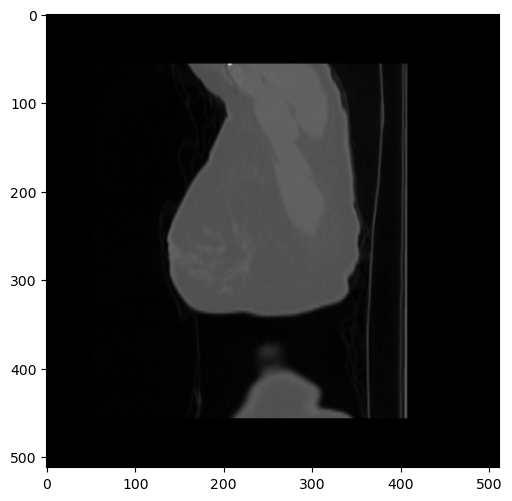

In [15]:
show_dicom(get_dicom_from_s3(data_lake_bucket, dicom_keys[len(dicom_keys)//2]))